# IFRC Events Analysis - Deaths by Event Type and Country

This notebook fetches emergency events from the IFRC GO API and visualizes deaths by event type for top countries.

## 1. Import Required Libraries

In [1]:
import os
import requests
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
print('Environment variables loaded successfully!')

Environment variables loaded successfully!


## 2. Define Functions

### 2.1 Get Authorization Headers

In [2]:
def get_auth_headers():
    """
    Get authorization headers using token from environment variable.
    
    Returns:
        dict: Headers dictionary with Authorization token
    """
    auth_token = os.getenv('IFRC_API_TOKEN')
    
    if not auth_token:
        raise ValueError('IFRC_API_TOKEN not found in environment. Please check your .env file.')
    
    return {"Authorization": f"Token {auth_token}"}

### 2.2 Fetch Events

In [3]:
def fetchEvents(regions_in, disaster_start_date_gte):
    """
    Fetch all events from the GO API for specified regions and date range.
    
    Args:
        regions_in: Region IDs to filter by (comma-separated string)
        disaster_start_date_gte: Start date filter (ISO format)
    
    Returns:
        list: List of event dictionaries from the API
    """
    base_url = "https://goadmin.ifrc.org/api/v2/event/"
    offset = 0
    page_size = 50
    all_results = []
    headers = get_auth_headers()

    while True:
        params = {
            "regions__in": regions_in,
            "disaster_start_date__gte": disaster_start_date_gte,
            "offset": offset,
            "limit": page_size
        }

        response = requests.get(base_url, params=params, headers=headers)
        
        # Check for successful response
        if response.status_code != 200:
            print(f"Error: API returned status code {response.status_code}")
            break
        
        data = response.json()
        events = data.get("results", [])

        if not events:
            break

        all_results.extend(events)
        print(f"Fetched {len(events)} events (total: {len(all_results)})")

        offset += page_size

    return all_results

## 3. Fetch Events Data

In [4]:
# Define parameters
regions_in = "0"  # Region ID (0 = Africa)
disaster_start_date_gte = "2012-01-01T00:00:00"

# Fetch events
events_data = fetchEvents(regions_in, disaster_start_date_gte)
print(f"\nTotal events fetched: {len(events_data)}")

Fetched 50 events (total: 50)
Fetched 50 events (total: 100)
Fetched 50 events (total: 150)
Fetched 50 events (total: 200)
Fetched 50 events (total: 250)
Fetched 50 events (total: 300)
Fetched 50 events (total: 350)
Fetched 50 events (total: 400)
Fetched 50 events (total: 450)
Fetched 50 events (total: 500)
Fetched 50 events (total: 550)
Fetched 50 events (total: 600)
Fetched 50 events (total: 650)
Fetched 50 events (total: 700)
Fetched 50 events (total: 750)
Fetched 50 events (total: 800)
Fetched 50 events (total: 850)
Fetched 50 events (total: 900)
Fetched 50 events (total: 950)
Fetched 50 events (total: 1000)
Fetched 50 events (total: 1050)
Fetched 50 events (total: 1100)
Fetched 50 events (total: 1150)
Fetched 50 events (total: 1200)
Fetched 50 events (total: 1250)
Fetched 50 events (total: 1300)
Fetched 24 events (total: 1324)

Total events fetched: 1324


## 4. Process Data

In [5]:
# Create DataFrame and explode nested columns
df = pd.DataFrame(events_data)
df = df.explode("countries")
df = df.explode("field_reports")

# Extract country names
df_country = pd.DataFrame(
    [country["name"] if pd.notnull(country) else None for country in df.countries],
    columns=["country.name"],
)

# Extract government death counts from field reports
gov_num_dead_list = pd.DataFrame(
    [x["gov_num_dead"] if pd.notnull(x) else None for x in df["field_reports"]],
    columns=["num_dead"],
)

# Extract disaster type names
df_dtype = pd.DataFrame(
    [name["name"] if pd.notnull(name) else None for name in df["dtype"]],
    columns=["dtype.name"],
)

# Combine all extracted data
df_final = pd.concat([df_dtype, df_country, gov_num_dead_list], axis=1)
print(f"Combined DataFrame shape: {df_final.shape}")
df_final.head()

Combined DataFrame shape: (1772, 3)


,dtype.name,country.name,num_dead
0,Flood,Zimbabwe,NaN
1,Flood,Mozambique,21.0
2,Population Movement,"Gambia, Republic of The",43.0
3,Other,Cameroon,NaN
4,Flood,Zambia,0.0


In [6]:
# Group by country and disaster type, summing the deaths
grouped_df = (
    df_final.groupby(["country.name", "dtype.name"])["num_dead"].sum().reset_index()
)

# Select the top 5 countries based on total deaths
top_countries = grouped_df.groupby("country.name")["num_dead"].sum().nlargest(5).index
grouped_top_df = grouped_df[
    grouped_df["country.name"].isin(top_countries)
].reset_index(drop=True)

grouped_top_df["num_dead"] = grouped_top_df["num_dead"].astype(int)

# Sort countries by total deaths
sorted_df = (
    grouped_top_df.groupby("country.name")["num_dead"]
    .sum()
    .reset_index()
    .sort_values(by="num_dead", ascending=True)
)

# Reorder the 'country.name' column based on the sorted order
grouped_top_df["country.name"] = pd.Categorical(
    grouped_top_df["country.name"], categories=sorted_df["country.name"], ordered=True
)

print("Top 5 countries by deaths:")
sorted_df

Top 5 countries by deaths:


,country.name,num_dead
1,Democratic Republic of Congo,1138
3,Nigeria,1776
4,Zimbabwe,2344
0,Chad,6792
2,Ghana,12059


In [7]:
# FIX: Create the pivot table (this was missing in original code!)
# The original code used 'df_pivoted' but never created it
df_pivoted = grouped_top_df.pivot_table(
    index="country.name",
    columns="dtype.name",
    values="num_dead",
    aggfunc="sum",
    fill_value=0
)

print("Pivoted DataFrame:")
df_pivoted

Pivoted DataFrame:


C:\Users\arun.gandhi\AppData\Local\Temp\ipykernel_16276\206981174.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivoted = grouped_top_df.pivot_table(


dtype.name,Biological Emergency,Chemical Emergency,Civil Unrest,Complex Emergency,Cyclone,Epidemic,Fire,Flood,Food Insecurity,Landslide,Other,Pluvial/Flash Flood,Population Movement,Storm Surge,Transport Accident,Volcanic Eruption
country.name,,,,,,,,,,,,,,,,
Democratic Republic of Congo,0,0,0,0,0,362,0,596,0,0,0,0,165,0,0,15
Nigeria,0,37,121,0,0,711,305,516,0,0,86,0,0,0,0,0
Zimbabwe,0,0,0,0,40,2301,0,0,0,0,3,0,0,0,0,0
Chad,0,0,0,0,0,83,0,341,0,0,0,0,6368,0,0,0
Ghana,0,17,0,0,0,0,0,12023,0,0,0,7,12,0,0,0


## 5. Visualize the Data

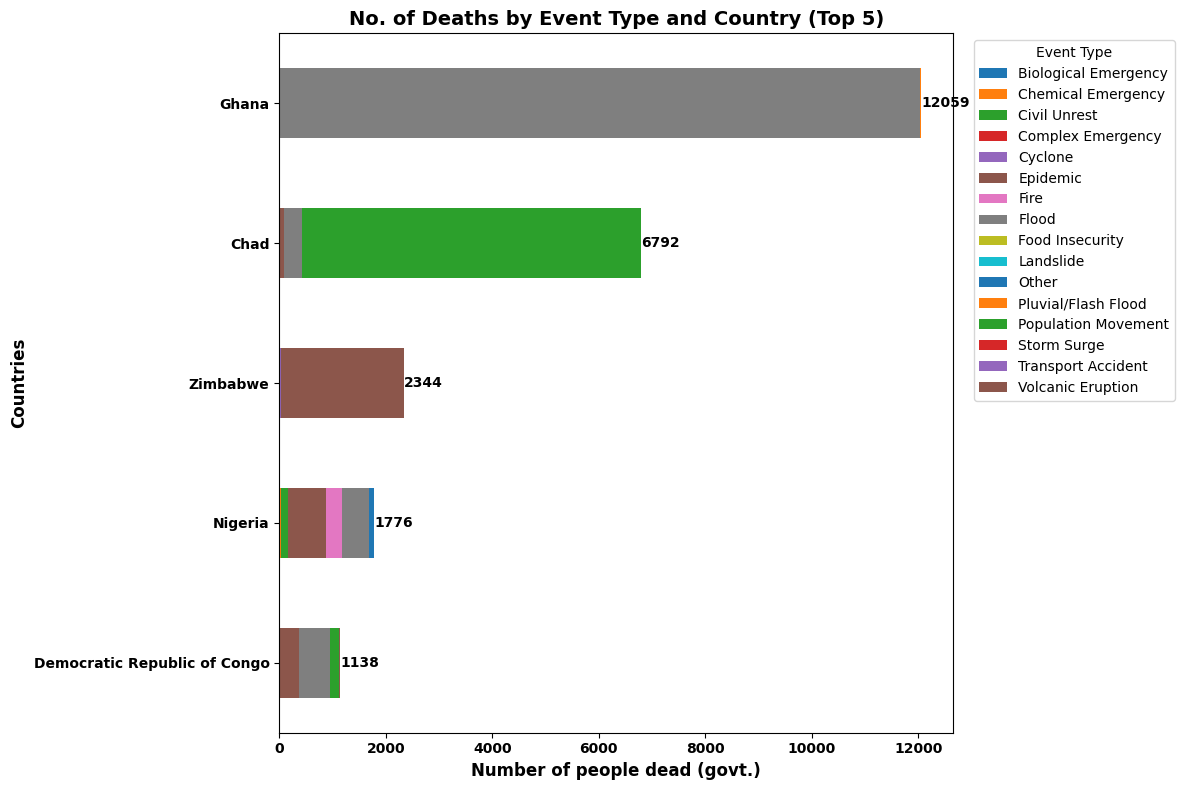

In [8]:
# Plot data in a horizontal stacked bar chart
ax = df_pivoted.plot(kind="barh", stacked=True, figsize=(12, 8))

# Add data labels for the total values next to each bar
for idx, value in enumerate(df_pivoted.sum(axis=1)):
    ax.text(value + 5, idx, str(int(value)), va="center", fontweight="bold")

# Add labels
plt.xlabel("Number of people dead (govt.)", fontweight="bold", fontsize=12)
plt.ylabel("Countries", fontweight="bold", fontsize=12)

# Make labels and ticks bold
plt.xticks(fontweight="bold")
plt.yticks(fontweight="bold")

plt.title("No. of Deaths by Event Type and Country (Top 5)", fontweight="bold", fontsize=14)
plt.legend(title="Event Type", bbox_to_anchor=(1.02, 1), loc='upper left')

# FIX: Added tight_layout and show (missing in original)
plt.tight_layout()
plt.show()